### Goal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import scipy.stats as stats
import numpy as np
import pandas as pd

# Set up plotting parameters for high-quality output
import matplotlib.pyplot as plt

sys.path.append("../../data_analysis/")
import helper as hp

In [3]:
savepath = "F03_24-12-3/"
os.makedirs(savepath, exist_ok=True)

In [4]:
root = "/Users/michaelmoret/tinyverse/krap/data/pulling_3_dec_24/formatted/"
for file in os.listdir(root):
    print(file)

.DS_Store
single
triple
summary


In [5]:
to_load = []
root = "/Users/michaelmoret/tinyverse/krap/data/pulling_3_dec_24/formatted/single/"
for file in os.listdir(root):
    if "summary" not in file and "single" in file:
        print(file)
        to_load.append(root + file)

20241203_NSK_IHNY_bleached_unwashed_old_batch_batch_1_batch_2_single_fiber.txt
20241203_NSK_IHNY_bleached_unwashed_(phos)_old_batch_batch_1_batch_2_single_phase.txt
20241203_EN_IHNY_bleached_SDS_wash_(phos)_old_batch_batch_1_batch_2_single.txt


In [6]:
path = to_load[0]
df_0= pd.read_csv(path, delimiter="\t")
df_0.head(2)

,RECORD,MEAN AREA,ESTIMATED_LENGTH(*),GRADIENT(*),EMOD(*)(#),DECRIMPING_WORK,EXTENSION_WORK,START_X(*),START_Y,END_X(*),END_Y,ANALYSIS_WORK,BREAK_STRAIN(*)(#),BREAK_LOAD,TENSILE_STRENGTH
0,1,2785.8,30.44,0.5439,5.943000e+09,-5.150000e-08,0.005881,0.2628,26.06,0.8870,62.86,0.000024,44.875,0.5308,190.5
1,2,3082.9,30.09,0.5708,5.571000e+09,4.096000e-07,0.003750,0.2326,15.43,0.8641,50.92,0.000019,29.711,0.4660,151.2


In [7]:
# Create a list with the new column values
name_values = ['old'] * 25 + ['batch 1'] * 25 + ['batch 2'] * 25
name_values = [f'unwashed^{x}' for x in name_values]
df_0['Name'] = name_values
print(len(df_0))
df_0 = df_0.dropna()
len(df_0)

75


74

In [8]:
path = to_load[1]
df_1 = pd.read_csv(path, delimiter="\t")
name_values = ['old'] * 25 + ['batch 1'] * 25 + ['batch 2'] * 25
name_values = [f'unwashed_(phos)^{x}' for x in name_values]
df_1['Name'] = name_values
print(len(df_1))
df_1 = df_1.dropna()
len(df_1)

75


70

In [ ]:
path = to_load[2]
df_2 = pd.read_csv(path, delimiter="\t")
name_values = ['old'] * 25 + ['batch 1'] * 25 + ['batch 2'] * 25
name_values = [f'SDS_wash_(phos)^{x}' for x in name_values]
df_2['Name'] = name_values
print(len(df_2))
df_2 = df_2.dropna()
len(df_2)

75


73

In [10]:
# Merge the three dataframes
df_merged = pd.concat([df_0, df_1, df_2], ignore_index=True)
len(df_merged)

217

## Helper Functions

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats
from itertools import combinations
import numpy as np

def create_boxplot(df, metric_column, group_column='Name', figsize=(10, 6)):
   """Create a compact boxplot with statistical test and median values"""
   
   # Create plot
   fig, ax = plt.subplots(figsize=figsize)
   
   # Function to remove outliers
   def remove_outliers(data):
       Q1 = np.percentile(data, 25)
       Q3 = np.percentile(data, 75)
       IQR = Q3 - Q1
       lower_bound = Q1 - 1.5 * IQR
       upper_bound = Q3 + 1.5 * IQR
       return data[(data >= lower_bound) & (data <= upper_bound)]
   
   # Get unique base names (before ^) and assign colors
   base_names = set([name.split('^')[0] for name in df[group_column].unique()])
   colors = plt.cm.Set3(np.linspace(0, 1, len(base_names)))
   color_dict = dict(zip(base_names, colors))
   
   # Create boxplot without outliers
   bp = df.boxplot(column=metric_column, 
                   by=group_column,
                   ax=ax,
                   grid=False,
                   showfliers=False,
                   medianprops={'color': 'red', 'linewidth': 1.5},
                   boxprops={'color': 'black'},
                   whiskerprops={'color': 'black'},
                   capprops={'color': 'black'},
                   patch_artist=True)
   
   # Color the boxes based on base names
   for i, box in enumerate(bp.patches):
       group_name = df[group_column].unique()[i]
       base_name = group_name.split('^')[0]
       box.set_facecolor(color_dict[base_name])
       box.set_alpha(0.7)
   
   # Remove top and right spines
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   
   # Get unique groups
   group_names = df[group_column].unique()
   
   # Add median values on top of each box
   for i, group in enumerate(group_names):
       median = df[df[group_column] == group][metric_column].median()
       ax.text(i+1, ax.get_ylim()[1]*1.02, f'Median: {median:.1f}', 
               horizontalalignment='center', fontsize=9)
   
   # Perform pairwise Mann-Whitney U tests without outliers
   pairs = list(combinations(group_names, 2))
   
   for group1_name, group2_name in pairs:
       # Get data and remove outliers
       group1_data = df[df[group_column] == group1_name][metric_column]
       group2_data = df[df[group_column] == group2_name][metric_column]
       
       group1_clean = remove_outliers(group1_data)
       group2_clean = remove_outliers(group2_data)
       
       stat, p_value = scipy.stats.mannwhitneyu(group1_clean, group2_clean, alternative='two-sided')
       if p_value < 0.05:  # Only print if statistically significant
           print(f"Statistical significance between {group1_name} and {group2_name}: p = {p_value:.4f}")
   
   # Only axis labels
   plt.suptitle('')
   plt.title('')
   plt.xticks(rotation=45, ha='right')
   plt.xlabel(group_column, fontsize=10)
   plt.ylabel(metric_column.replace('_', ' ').title(), fontsize=10)
   ax.yaxis.grid(True, linestyle='--', alpha=0.3)
   
   plt.tight_layout()  
   
   return fig, ax

In [12]:
df_merged.columns

Index(['RECORD', 'MEAN AREA', 'ESTIMATED_LENGTH(*)', 'GRADIENT(*)',
       'EMOD(*)(#)', 'DECRIMPING_WORK', 'EXTENSION_WORK', 'START_X(*)',
       'START_Y', 'END_X(*)', 'END_Y', 'ANALYSIS_WORK', 'BREAK_STRAIN(*)(#)',
       'BREAK_LOAD', 'TENSILE_STRENGTH', 'Name'],
      dtype='object')

Statistical significance between unwashed^batch 1 and SDS_wash_(phos)^old: p = 0.0382
Statistical significance between unwashed^batch 2 and SDS_wash_(phos)^old: p = 0.0068
Statistical significance between unwashed_(phos)^old and SDS_wash_(phos)^old: p = 0.0233


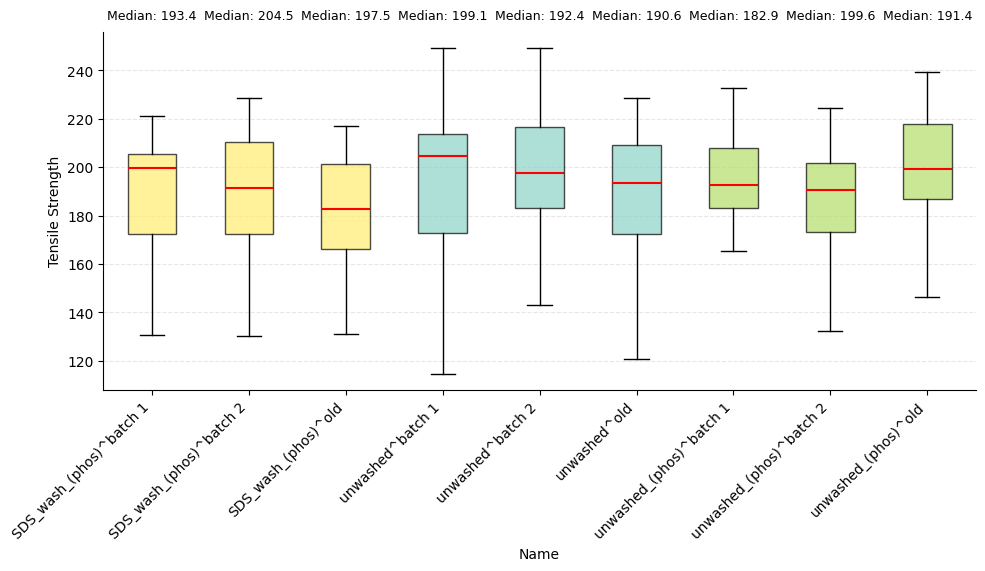

In [13]:
fig, ax = create_boxplot(df_merged, 'TENSILE_STRENGTH')
plt.show()

Statistical significance between unwashed_(phos)^old and SDS_wash_(phos)^batch 1: p = 0.0469


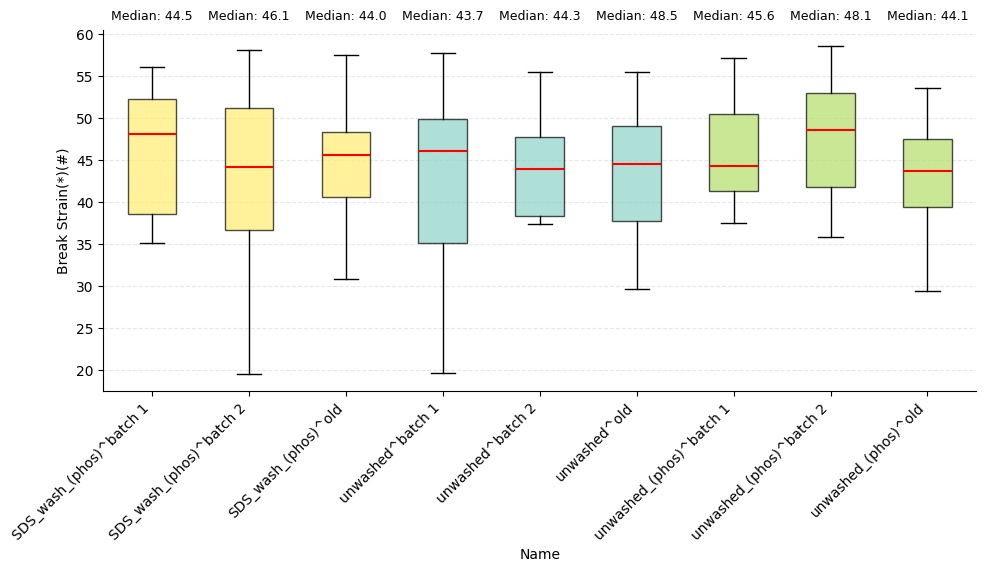

In [14]:
fig, ax = create_boxplot(df_merged, 'BREAK_STRAIN(*)(#)')
plt.show()

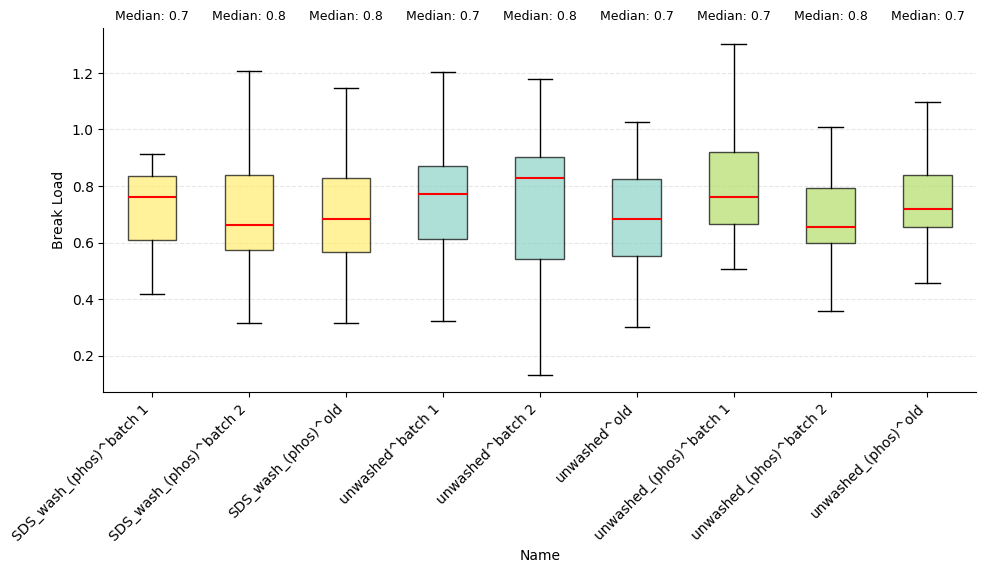

In [15]:
fig, ax = create_boxplot(df_merged, 'BREAK_LOAD')
plt.show()